# Prediction - European Calls

In [1]:
%run key_imports.py
%run nn_archi.py
%run utils.py

X_df = pd.read_csv("datasets/rough_bergomi.csv")
feat_names = ["log-strike", "ttm", "alpha", "rho", "vol-of-vol"]
f_to_i = lambda x: feat_names.index(x)
Xs = X_df[feat_names].values
ys = X_df['call_payoff']


moneyness = np.exp(-Xs[:, f_to_i("log-strike")])
ttm = np.exp(Xs[:, f_to_i("ttm")])
true = X_df['call_payoff']
intrinsic_val = np.maximum(1.0 - moneyness, 0)

print("BASELINE MSE: ", np.mean((ys - ys.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys - ys.mean())))

all_res = []

BASELINE MSE:  0.018329220541525755
BASELINE MAE:  0.11977829146428666


In [2]:
HIDDEN_UNITS = 100
LAYERS = 2
dropout_ratio = 0.0
HIDDEN_ACT = 'softplus'
N_FEATS = Xs.shape[1]
OUTPUT_ACT = None
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30
BATCH_NORM = False

loss_fn = tf.keras.losses.MeanSquaredError()

METRICS = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
VAL_SPLIT = 0.2
CALLBACKS = [tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)] + [EarlyStopping(patience=10)]

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

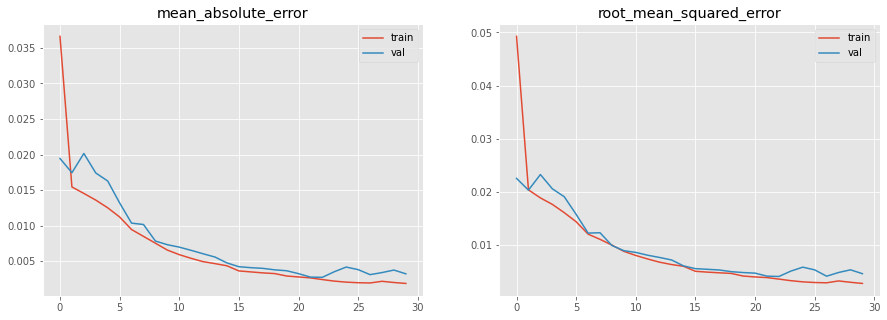

In [3]:
opt = Adam(learning_rate = LR)
ffn = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)


ffn.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
start = time.time()
history = ffn.fit(Xs, ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  shuffle=False,
                  verbose = 0,
                  callbacks=CALLBACKS)
end = time.time()

metrics = ['mean_absolute_error', 'root_mean_squared_error']
fig, ax = plt.subplots(figsize=(15, 5), ncols = 2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)

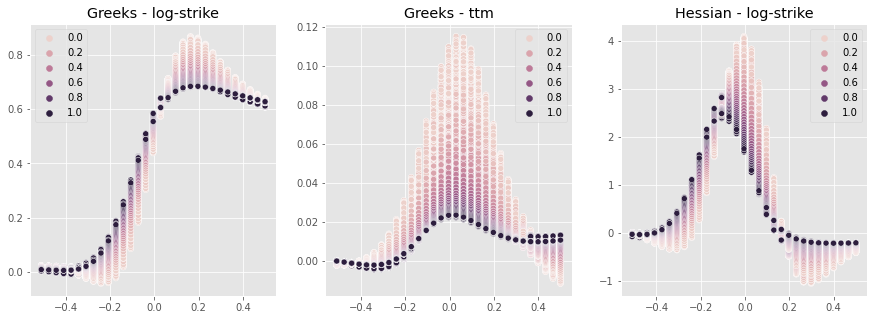

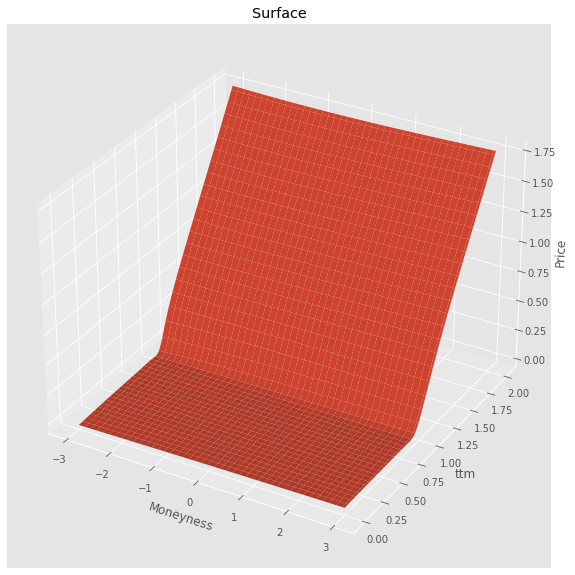

In [4]:
"""
Prediction Errors
"""
model = ffn
preds = model.predict(Xs)
try:
    preds = preds.reshape(-1)
except:
    pass

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log-strike")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()

temp = pd.concat([pd.DataFrame(diagnosis_pred(X_df['call_payoff'], preds, lower_bound = intrinsic_val),
             index = ['ffn']),
             pd.DataFrame(diagnosis_grads(hessian_moneyness, grads, f_to_i, "ttm", "log-strike"),
                          index=['ffn'])], axis = 1)
temp['total_time'] = end - start

fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))
for i, x in enumerate(['log-strike', 'ttm']):
    sns.scatterplot(Xs[:, f_to_i('log-strike')], 
                    grads[:, f_to_i(x)],
                    hue = Xs[:, f_to_i("ttm")],
                    ax = ax[i])
    ax[i].set_title(f"Greeks - {x}")
    
sns.scatterplot(Xs[:, f_to_i('log-strike')], hessian_moneyness[:, f_to_i("log-strike")], ax = ax[2], hue = Xs[:, f_to_i("ttm")])
ax[2].set_title(f"Hessian - log-strike")

all_res += [temp]

"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS) 
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS ** 2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log-strike"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])
        
temp = visualise_surface(SK, ts, model(X).numpy())

# NN with a homogeneity hint

In [6]:
opt = Adam(learning_rate = LR)
gated_model = homogeneity_network(N_FEATS, 100, seed = 42)
gated_model.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
start = time.time()
history = gated_model.fit([Xs[:,0], Xs[:,1], Xs[:, 2:]], 
                    ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  verbose = 0,
                  shuffle=True,
                  callbacks=CALLBACKS)
end = time.time()
print(end - start)

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

116.9221727848053


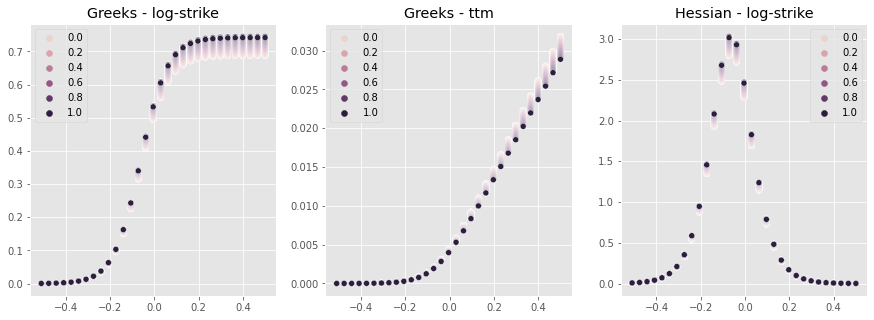

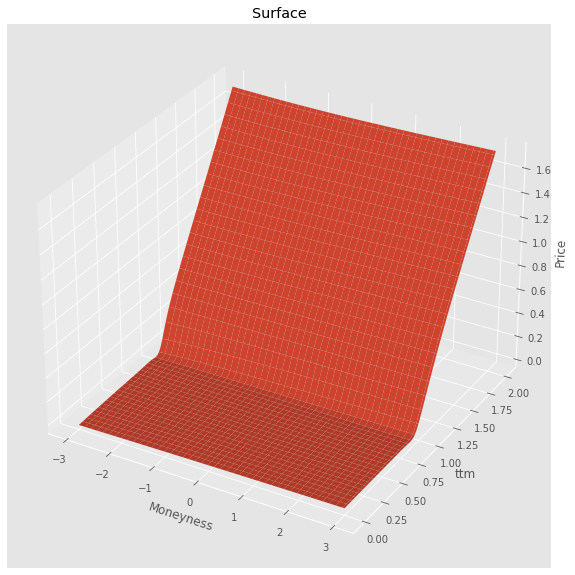

In [7]:
preds = (gated_model.predict([Xs[:,0], Xs[:,1], Xs[:, 2:]]).reshape(-1)).reshape(-1)

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = gated_model([X_tensor[:,0], X_tensor[:,1], X_tensor[:, 2:]])
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log-strike")], X_tensor)
    
grads = grads.numpy()
hessian_moneyness = hessian1.numpy()


temp = pd.concat([pd.DataFrame(diagnosis_pred(X_df['call_payoff'], preds, lower_bound = intrinsic_val),
             index = ['gated']),
             pd.DataFrame(diagnosis_grads(hessian_moneyness, grads, f_to_i, "ttm", "log-strike"),
                          index=['gated'])], axis = 1)
temp['total_time'] = end - start

fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))
for i, x in enumerate(['log-strike', 'ttm']):
    sns.scatterplot(Xs[:, f_to_i('log-strike')], 
                    grads[:, f_to_i(x)],
                    hue = Xs[:, f_to_i("ttm")],
                    ax = ax[i])
    ax[i].set_title(f"Greeks - {x}")
    
sns.scatterplot(Xs[:, f_to_i('log-strike')], hessian_moneyness[:, f_to_i("log-strike")], ax = ax[2], hue = Xs[:, f_to_i("ttm")])
ax[2].set_title(f"Hessian - log-strike")

all_res += [temp]

"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS) 
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS ** 2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log-strike"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])
        
temp = visualise_surface(SK, ts, model(X).numpy())

# Polynomial Basis

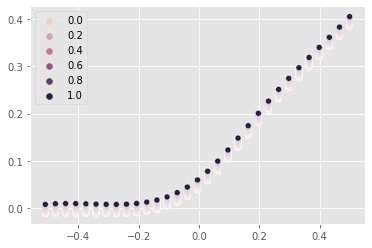

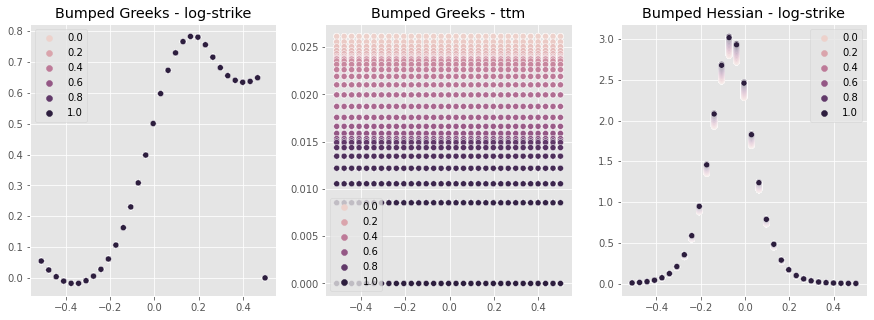

In [8]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
start = time.time()
spline = SplineTransformer(n_knots=5, degree=3, knots='uniform', extrapolation='constant')
X2 = spline.fit_transform(Xs)
reg = LinearRegression(fit_intercept=False).fit(X2, X_df['call_payoff'])
preds = reg.predict(X2)
Xs_bumped = Xs.copy()
eps = 1e-4
# strike
bumped_greeks = np.zeros((Xs.shape[0], Xs.shape[1]))
bumped_hessian = np.zeros((Xs.shape[0], Xs.shape[1]))

Xs_bumped[:, f_to_i("log-strike")] += eps
X2_bumped = spline.transform(Xs_bumped)
preds2 = reg.predict(X2_bumped)
bumped_greeks[:, f_to_i("log-strike")] = (preds2 - preds) / eps

Xs_bumped2 = Xs.copy()
Xs_bumped2[:, f_to_i("log-strike")] -= eps
X2_bumped2 = spline.transform(Xs_bumped2)
preds3 = reg.predict(X2_bumped2)
bumped_hessian[:, f_to_i("log-strike")] = (preds2 - 2 * preds + preds3) / (eps * eps)

eps = 1e-2
Xs_bumped3 = Xs.copy()
Xs_bumped3[:, f_to_i("ttm")] += eps
X2_bumped3 = spline.transform(Xs_bumped3)
preds4 = reg.predict(X2_bumped3)
bumped_greeks[:, f_to_i("ttm")] = (preds4 - preds) / (eps)


end = time.time()
sns.scatterplot(x = Xs[:, f_to_i("log-strike")], 
                y = preds, 
                hue = Xs[:, f_to_i("ttm")])



temp = pd.concat([pd.DataFrame(diagnosis_pred(X_df['call_payoff'], preds, lower_bound = intrinsic_val),
             index = ['polynomial']),
             pd.DataFrame(diagnosis_grads(bumped_hessian, bumped_greeks, f_to_i, "ttm", "log-strike"),
                          index=['polynomial'])], axis = 1)
temp['total_time'] = end - start

fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))
for i, x in enumerate(['log-strike', 'ttm']):
    sns.scatterplot(Xs[:, f_to_i('log-strike')], 
                    bumped_greeks[:, f_to_i(x)],
                    hue = Xs[:, f_to_i("ttm")],
                    ax = ax[i])
    ax[i].set_title(f"Bumped Greeks - {x}")
    
sns.scatterplot(Xs[:, f_to_i('log-strike')], hessian_moneyness[:, f_to_i("log-strike")], ax = ax[2], hue = Xs[:, f_to_i("ttm")])
ax[2].set_title(f"Bumped Hessian - log-strike")

all_res += [temp]

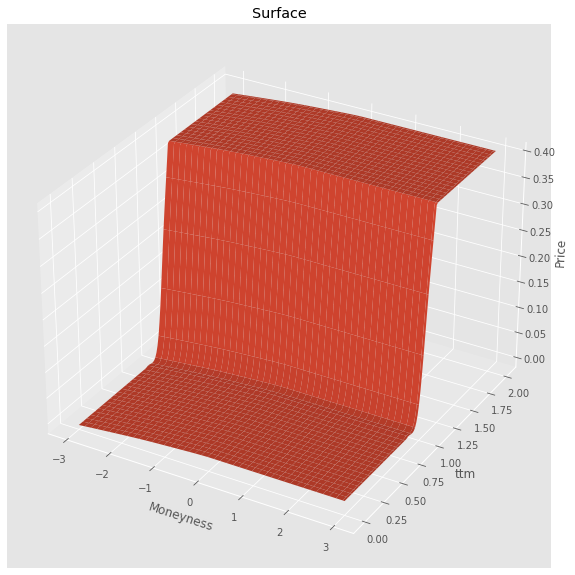

In [9]:
"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS) 
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS ** 2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log-strike"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])
        
temp = visualise_surface(SK, ts, reg.predict(spline.transform(X)))

In [10]:
res_df = pd.concat(all_res).drop_duplicates().T
print(res_df.style.format("{:.5f}").to_latex())
res_df.style.background_gradient(axis = 1)

\begin{tabular}{lrrr}
{} & {ffn} & {gated} & {polynomial} \\
l1 & 0.00316 & 0.00532 & 0.00447 \\
l2 & 0.00447 & 0.00808 & 0.00601 \\
l_inf & 0.03383 & 0.05344 & 0.04127 \\
lower_bound_violation & 0.11413 & 0.10864 & 0.21770 \\
monotonicity_error & 0.05237 & 0.00000 & 0.12903 \\
time_value_error & 0.24469 & 0.00000 & 0.00000 \\
convex_error & 0.52610 & 0.00000 & 0.37017 \\
total_time & 139.51457 & 116.92217 & 0.48880 \\
\end{tabular}



,ffn,gated,polynomial
l1,0.003157,0.005325,0.004469
l2,0.004467,0.008079,0.006009
l_inf,0.033834,0.053444,0.041274
lower_bound_violation,0.114131,0.108637,0.217700
monotonicity_error,0.052373,0.000000,0.129032
time_value_error,0.244693,0.000000,0.000000
convex_error,0.526098,0.000000,0.370166
total_time,139.514566,116.922173,0.488804


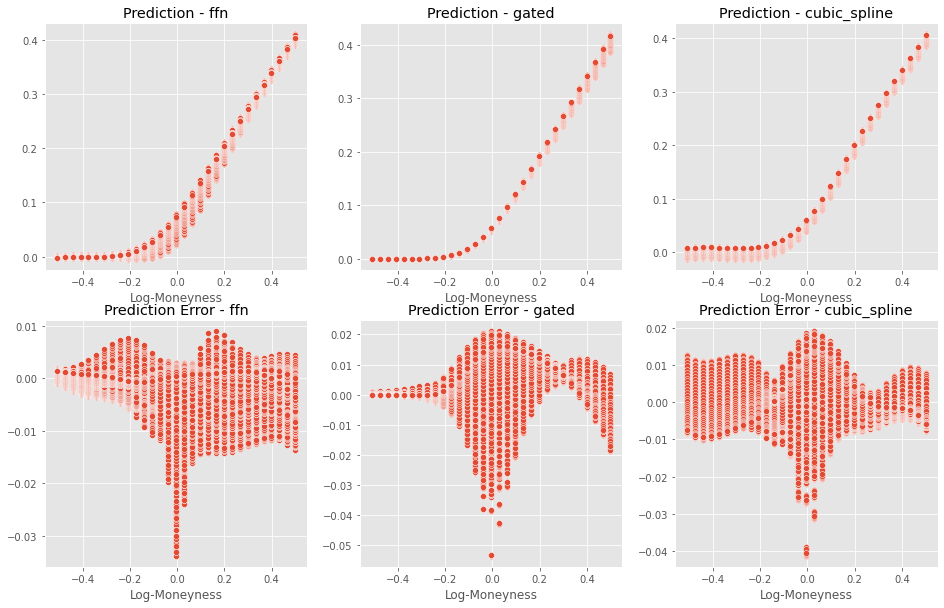

In [11]:
error_ffn = ys.values - ffn.predict(Xs).reshape(-1)
fig, ax = plt.subplots(ncols = 3, figsize=(16, 10), nrows = 2)
sns.scatterplot(Xs[:, f_to_i("log-strike")], ffn.predict(Xs).reshape(-1), ax = ax[0, 0])
sns.scatterplot(Xs[:, f_to_i("log-strike")], error_ffn, ax = ax[1, 0])
sns.scatterplot(Xs[:, f_to_i("log-strike")], gated_model.predict([Xs[:,0], Xs[:, 1], Xs[:, 2:]]).reshape(-1), ax = ax[0, 1])
error_gated = ys.values - gated_model.predict([Xs[:,0], Xs[:, 1], Xs[:, 2:]]).reshape(-1)
sns.scatterplot(Xs[:, f_to_i("log-strike")], error_gated, ax = ax[1, 1])
error_poly = ys.values - reg.predict(spline.transform(Xs))
sns.scatterplot(Xs[:, f_to_i("log-strike")], reg.predict(spline.transform(Xs)), ax = ax[0, 2])
sns.scatterplot(Xs[:, f_to_i("log-strike")], error_poly, ax = ax[1, 2])

for i, x in enumerate(['ffn','gated', 'cubic_spline']):
    ax[0, i].set_title(f"Prediction - {x}")
    ax[0, i].set_xlabel("Log-Moneyness")
    ax[1, i].set_title(f"Prediction Error - {x}")
    ax[1, i].set_xlabel("Log-Moneyness")